In [32]:
#!jupyter nbconvert --to script SVM_Training.ipynb
from __future__ import print_function
import sys
import os
import numpy as np
import shutil
sys.path.insert(0, os.path.join('..', '..'))
import datetime
import sklearn.metrics
from matplotlib import pyplot as plt
import pandas
from multiprocessing import Pool
from contextlib import closing
import pickle as pl
import matplotlib
from gait_analysis.utils.data_loading import mkdir_p
from gait_analysis.plotting import barplot, FigSaver
from gait_analysis import settings as S
%matplotlib inline

** choosing matplotlib style **

# 0. Settings

In [33]:
exp_folder = r'/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/'
auswertung_folder = exp_folder
mkdir_p(os.path.join(auswertung_folder))
sub_folders = sorted([os.path.join(exp_folder, o) for o in os.listdir(exp_folder) if os.path.isdir(os.path.join(exp_folder, o))])

report_folder = os.path.join(S.exp_reports_root, 'exp_1')
mkdir_p(report_folder)
f_saver = FigSaver(report_folder, plt_savefig_kwargs={'dpi' : 250})

## 0.1 options tuple from launcher

(temporal_extent, body_keypoints_include_list)

In [34]:
from itertools import product
body_keypoints_include_list=[
    'LAnkle',
    'RAnkle',
    'LKnee',
    'RKnee',
    'RHip',
    'LHip',
]
all_options = [body_keypoints_include_list[:i] for i in range(1, len(body_keypoints_include_list))]
opt_tuple_list = list(product(range(6), all_options))
print(opt_tuple_list[0])

def opt_tuple2string(opt_tuple):
    return '{}, {}'.format(opt_tuple[0], ' + '.join(opt_tuple[1]))
    

opt_tuple_string_list = list(map(opt_tuple2string, opt_tuple_list))
print(opt_tuple_string_list[1])

(0, ['LAnkle'])
0, LAnkle + RAnkle


# 1.0 Calculate over all accuracy, precision and recall

In [35]:
metrics = [
    sklearn.metrics.accuracy_score,
    sklearn.metrics.precision_score,
    sklearn.metrics.recall_score,
]
metric_titles = [
    'Accuracy',
    'Precision',
    'Recall',
]



In [36]:
def process_subfolders(sub_folders):    
    def process_subfolder(sub_folder):
        df = pandas.read_pickle(os.path.join(sub_folder, "results.pickle"))
        data_frame = df
        cols = data_frame.columns    
        all_targets = np.hstack([np.array(data_frame[idx]['target']) for idx in cols])
        all_predictions = np.hstack([np.array(data_frame[idx]['prediction']).squeeze()] for idx in cols).squeeze()

        output = {
            'targets' : all_targets,
            'predictions' : all_predictions,
        }
        return output

    outputs = list(map(process_subfolder, sub_folders))

    return outputs

output = process_subfolders(sub_folders)


<gait_analysis.plotting.FigSaver instance at 0x7f5a3946bc20>

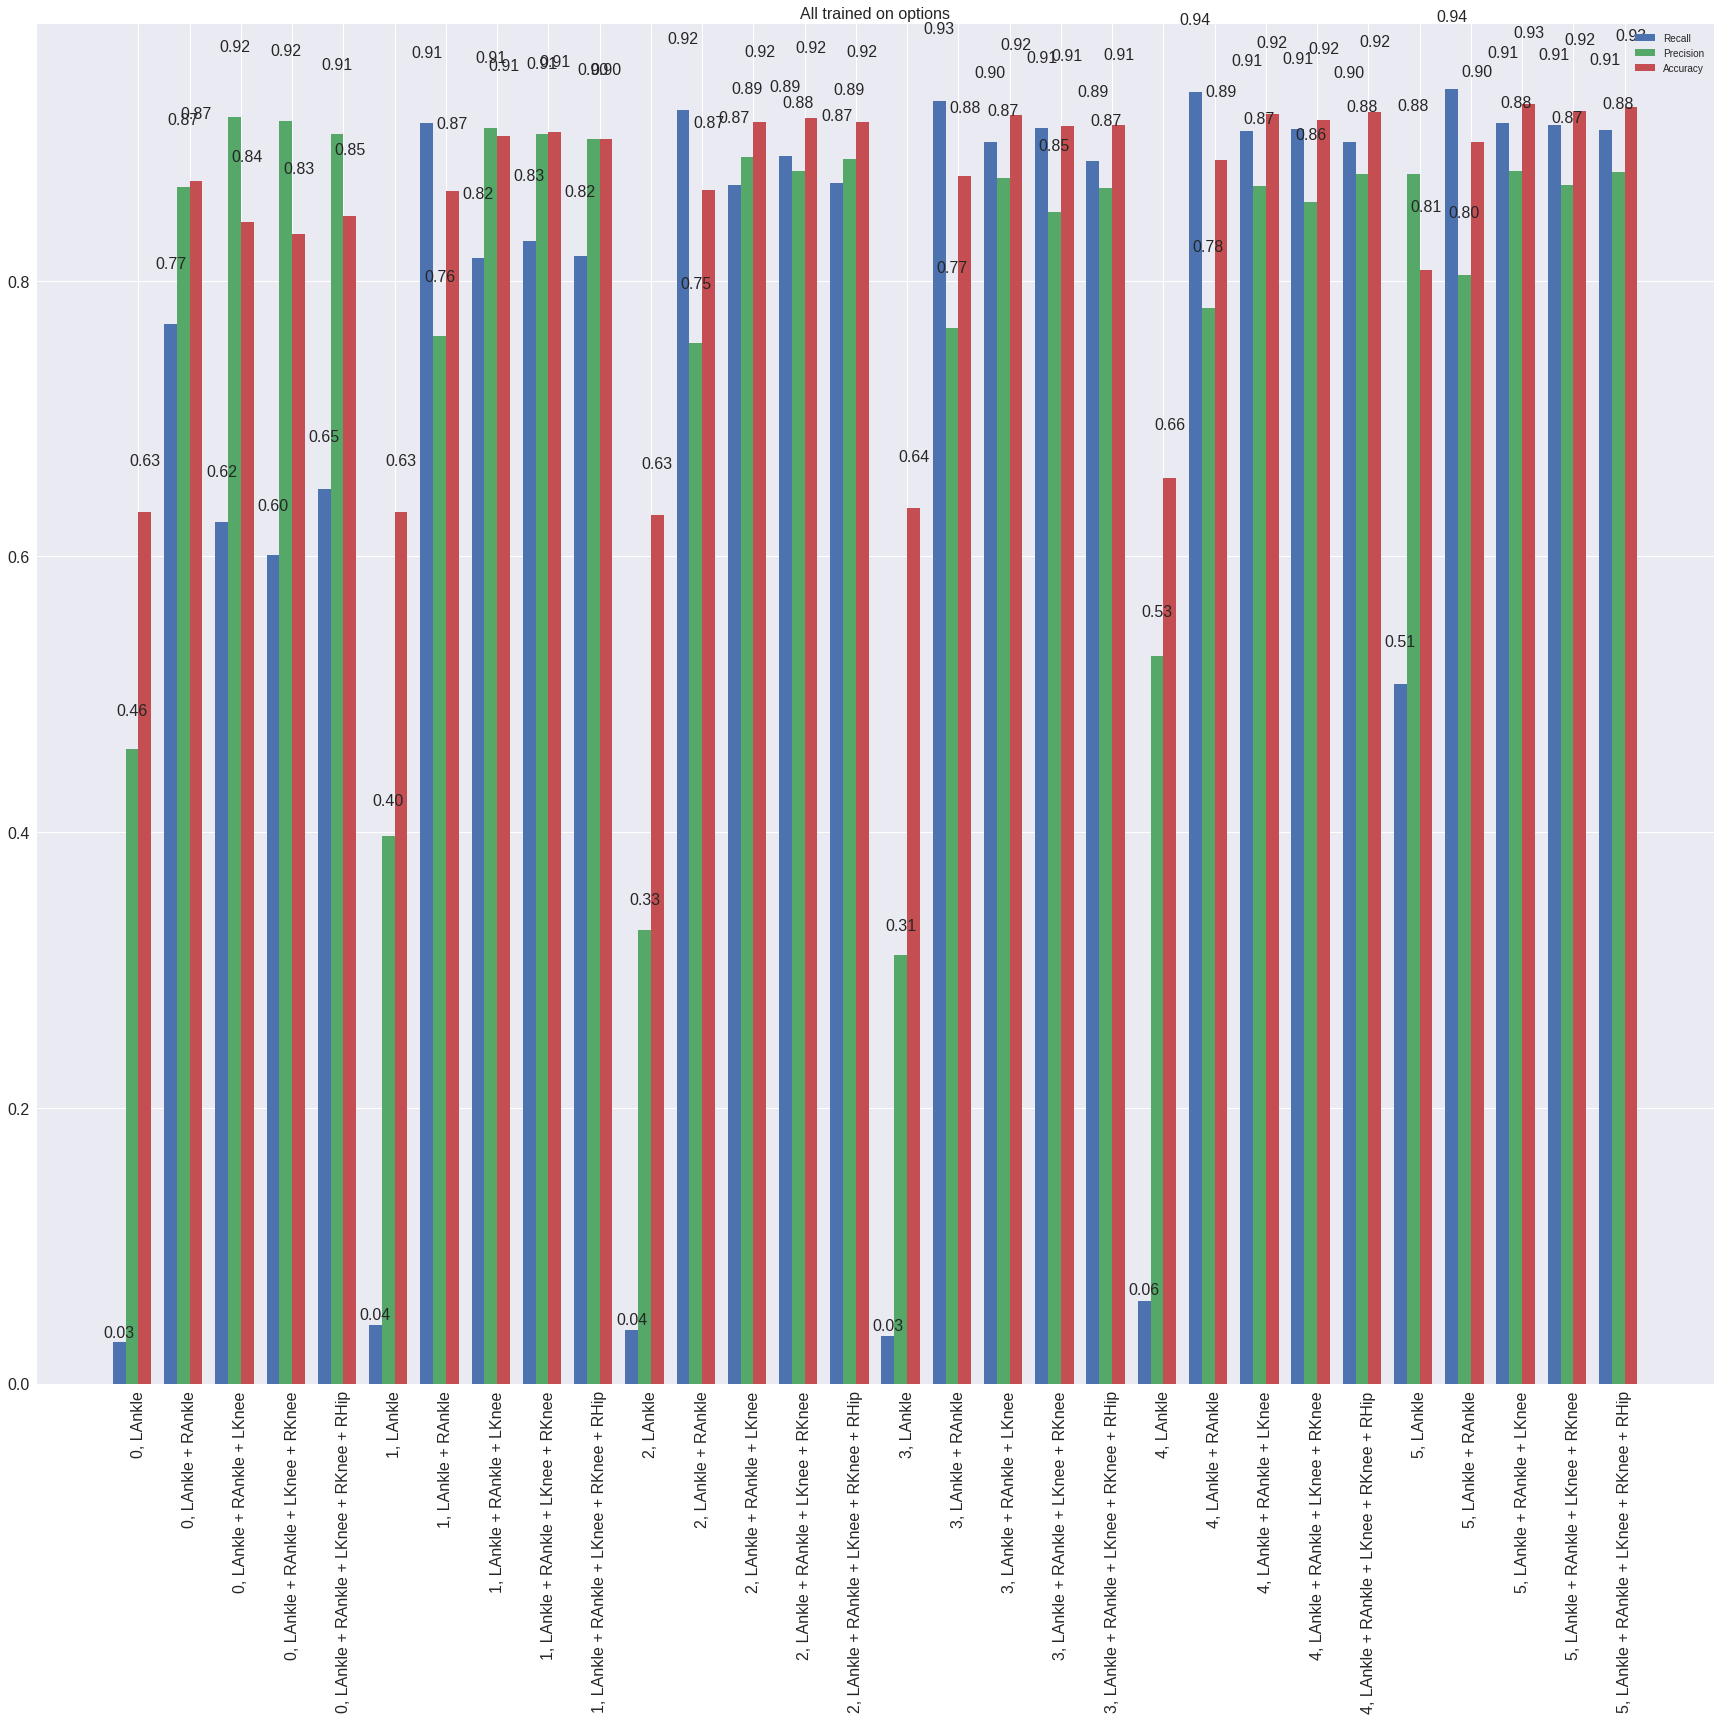

In [37]:
data_dict = {}
for m, m_text in zip(metrics, metric_titles):
    fs = 16
    scores = []
    for o in output:
        y_true = o['targets']
        y_pred = o['predictions']
        scores.append(m(y_true, y_pred))
    data_dict[m_text] = (scores, np.zeros_like(scores))


fig, ax = plt.subplots(1,1, figsize=(24, 24))
fig, ax = barplot(fig, ax, data_dict)
ax.set_xticklabels(opt_tuple_string_list, rotation=90, fontsize=16)
ax.set_title('All trained on options', fontsize=16)
fig.tight_layout()
f_saver.save_fig(fig, 'all_options').next()

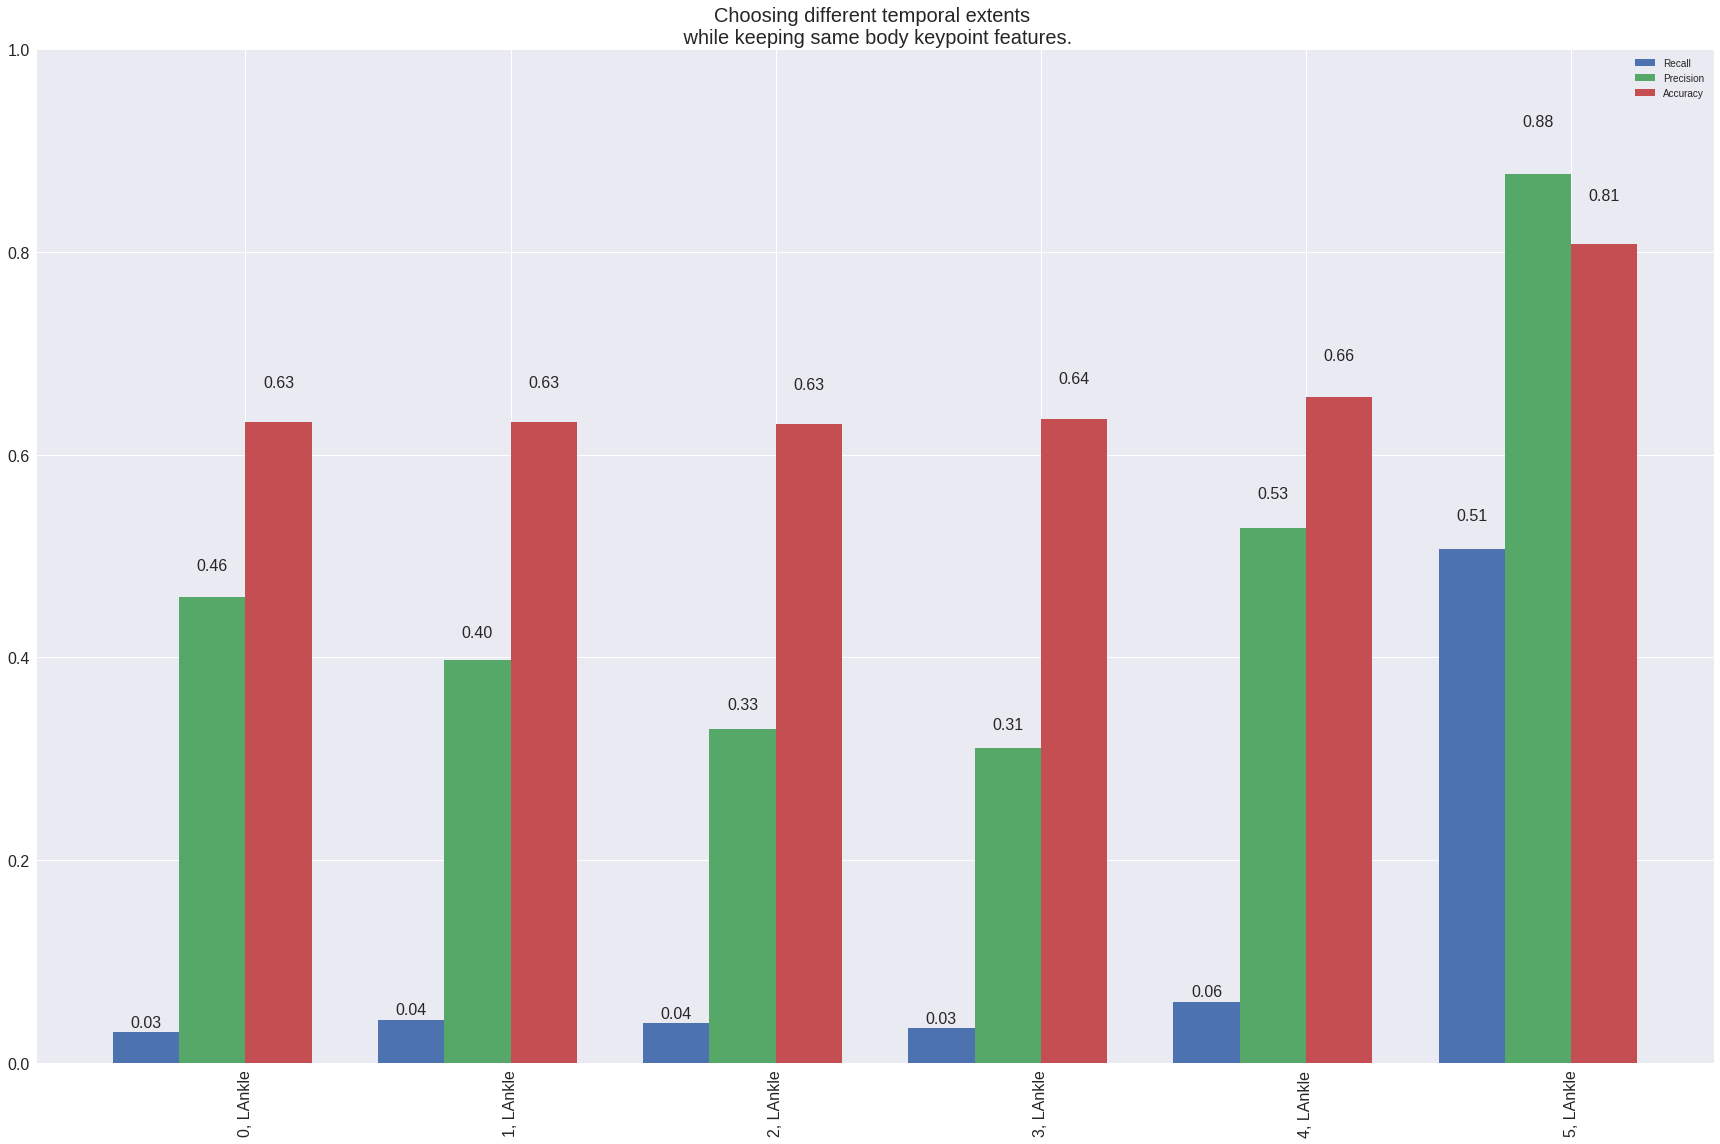

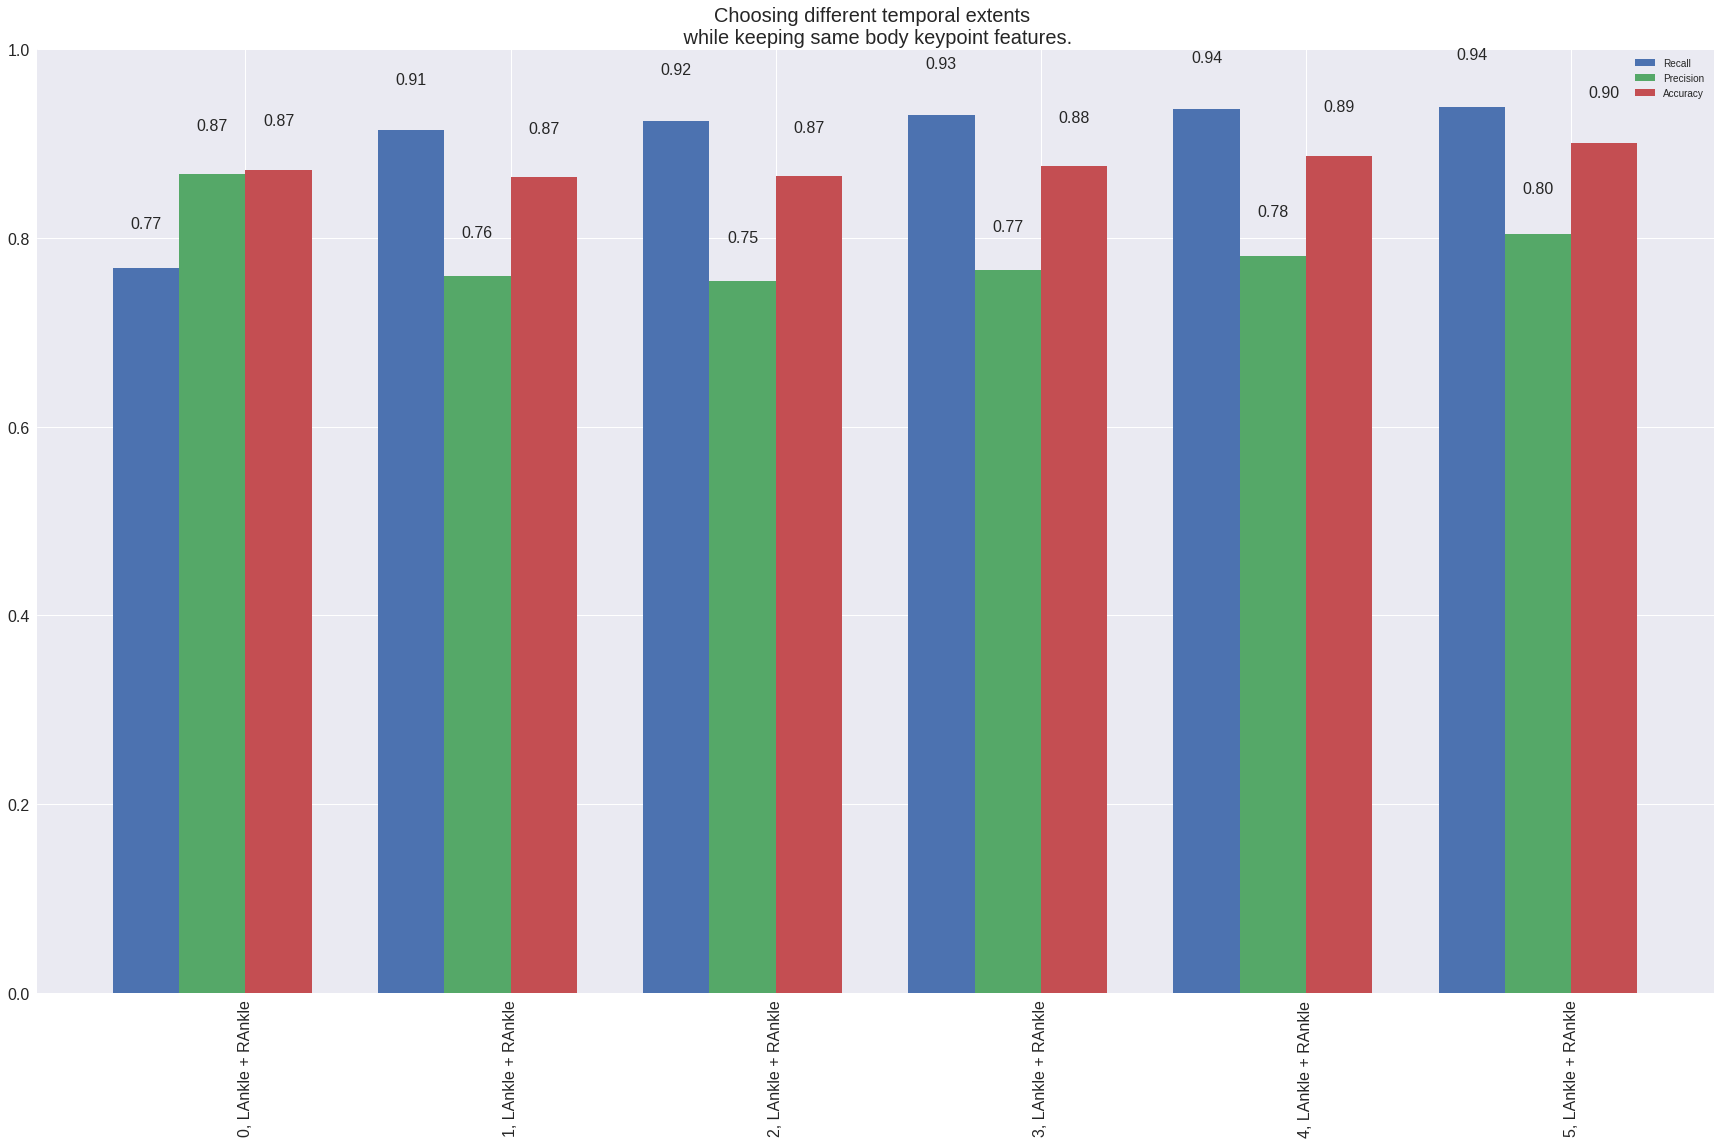

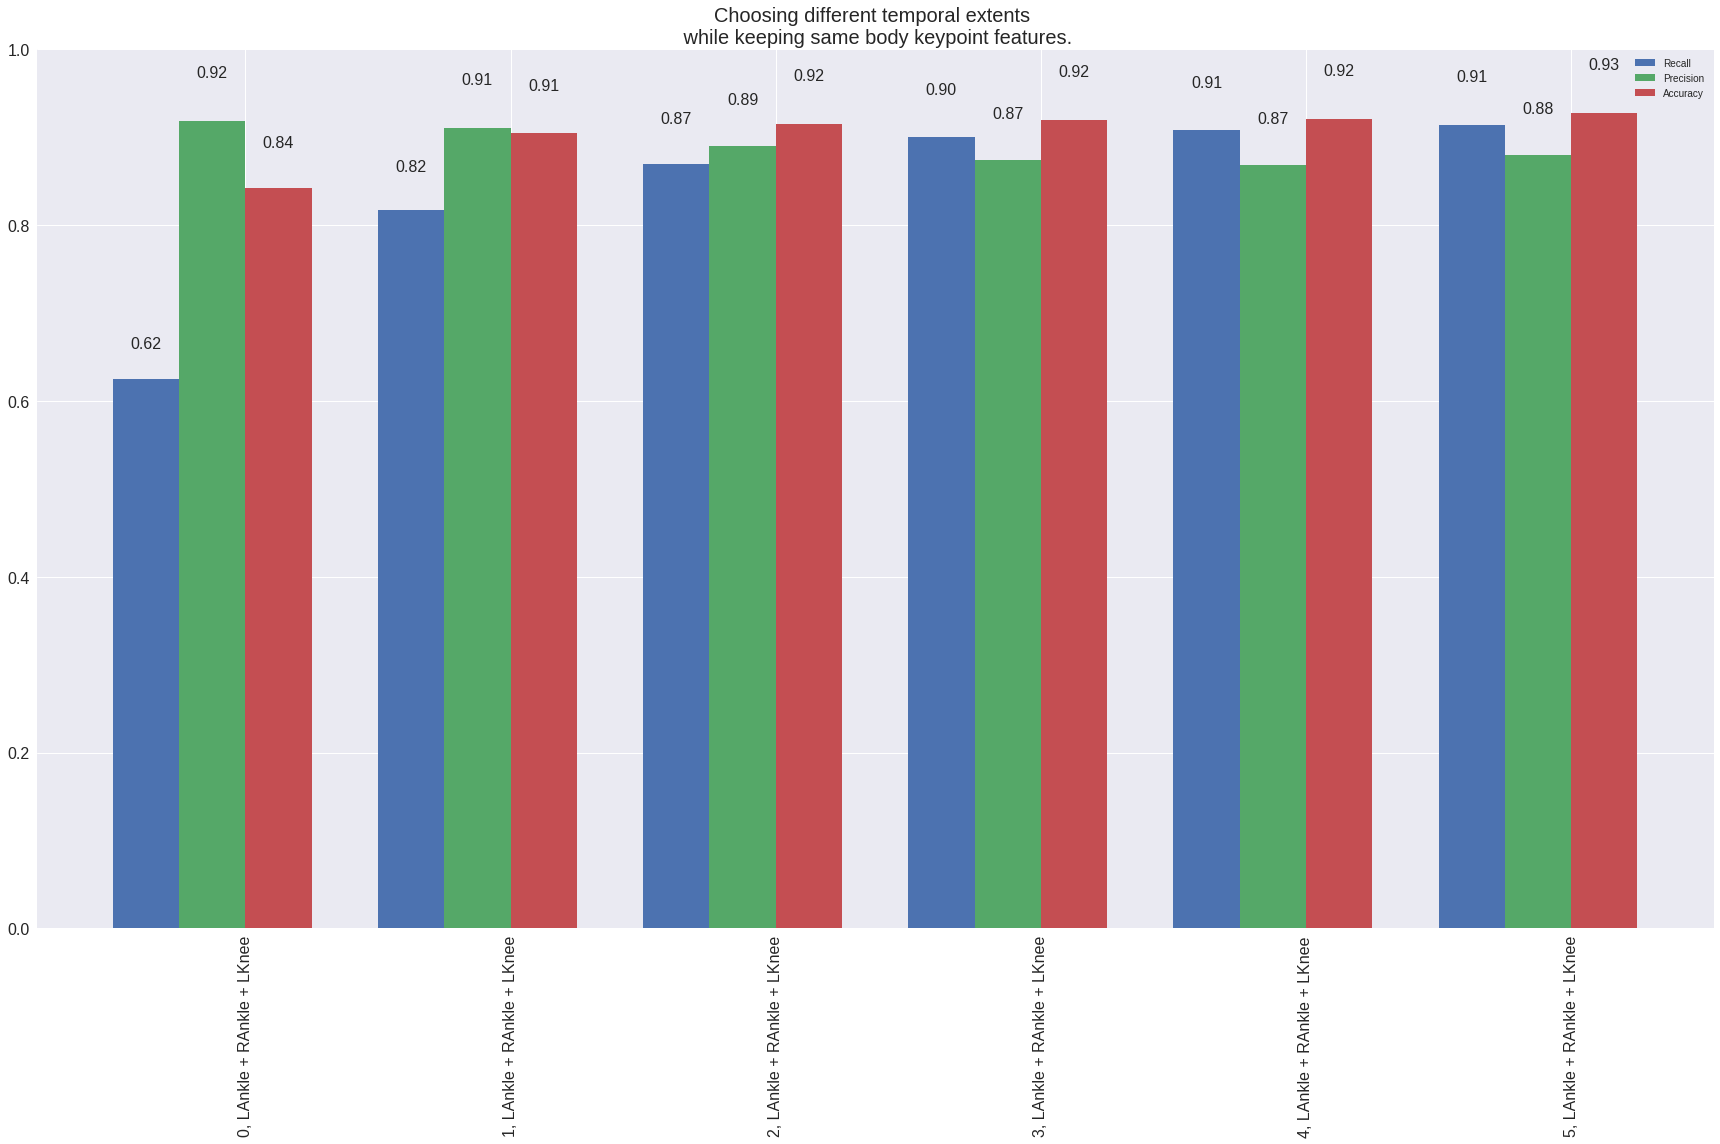

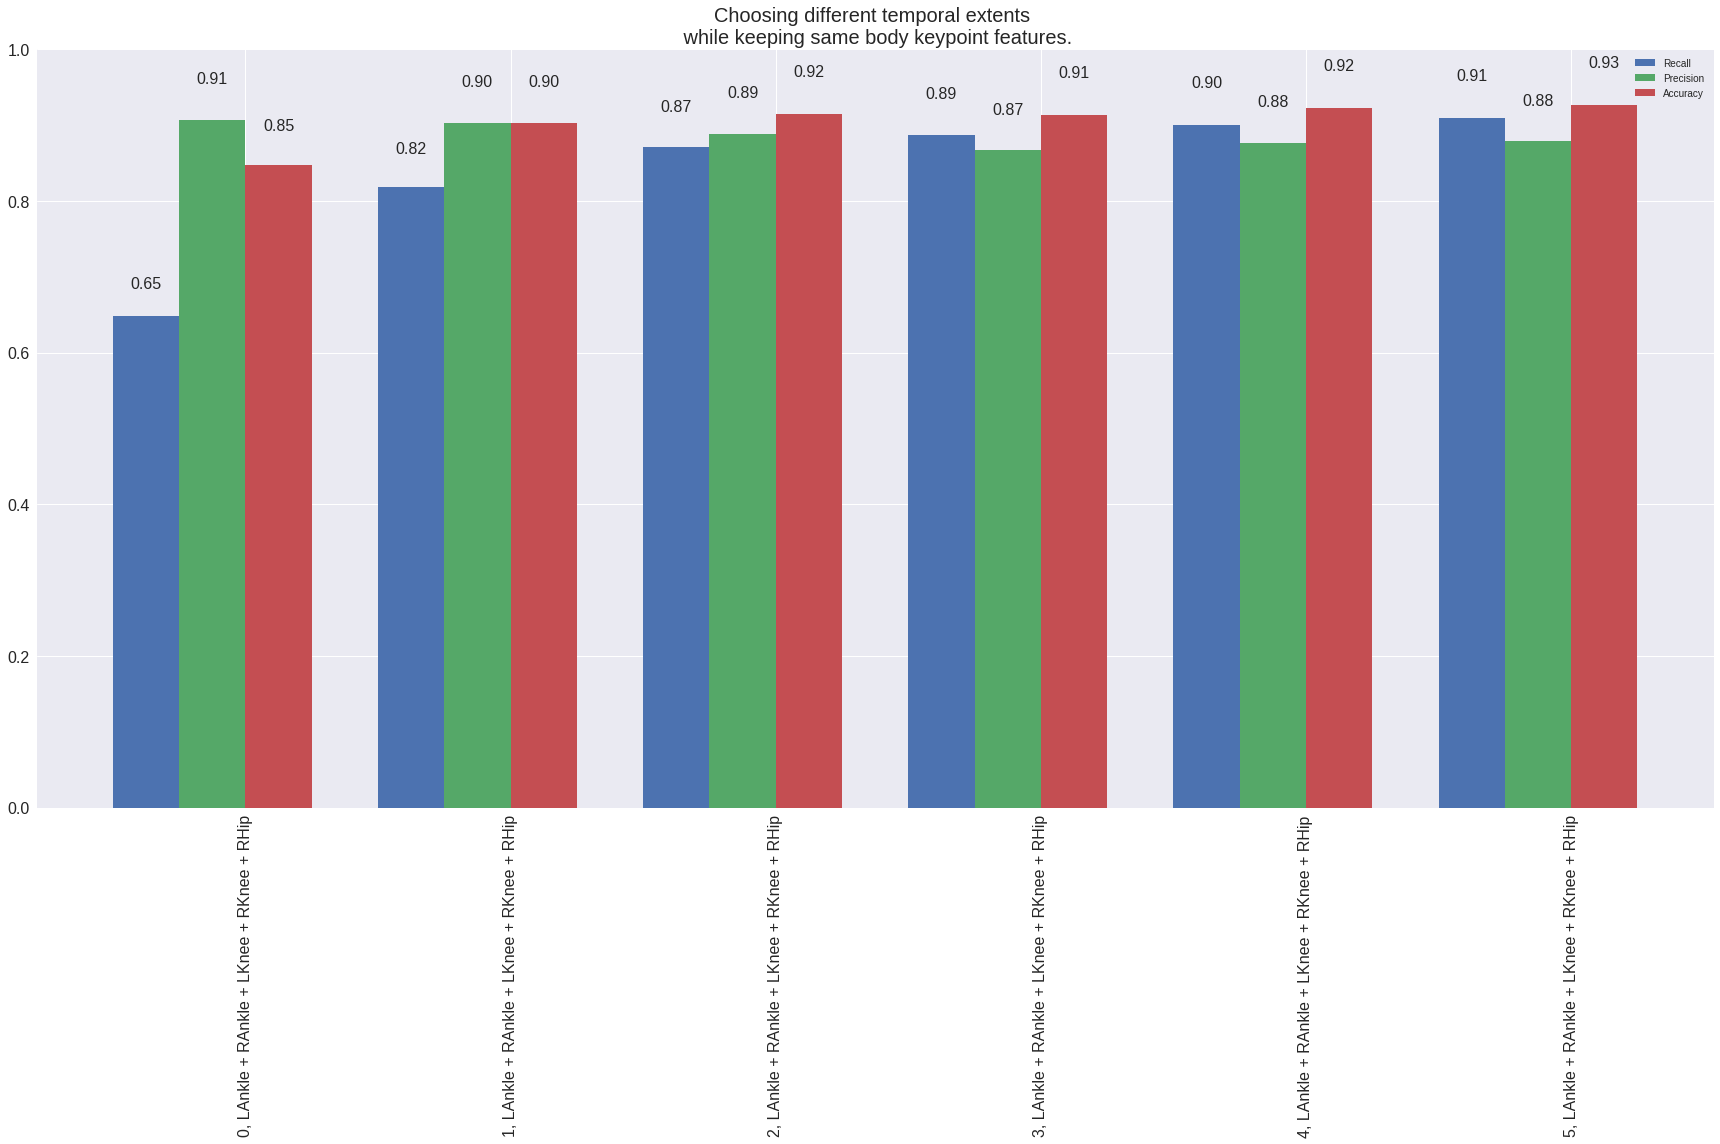

In [38]:
def filter_data_dict(data_dict, i=2, offset=0):
    new_data_dict = {key: (val_tuple[0][offset::i], None) for key, val_tuple in data_dict.iteritems()}
    return new_data_dict


f_saver.set(1)
for offset in [0, 1, 2, 4]:
    new_data_dict = filter_data_dict(data_dict, 5, offset)
    fig, ax = plt.subplots(1,1, figsize=(24, 16))
    fig, ax = barplot(fig, ax, new_data_dict)
    x_ticks = opt_tuple_string_list[offset::i]
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=16)
    ax.set_title('Choosing different temporal extents \n while keeping same body keypoint features.',
                fontsize=20)
    ax.set_ylim([0, 1])
    fig.tight_layout()
    f_saver.save_fig(fig, 'num_keypoints_is_{}'.format(offset+1)).next()

## Choosing different number of keypoints while keeping temporal extent

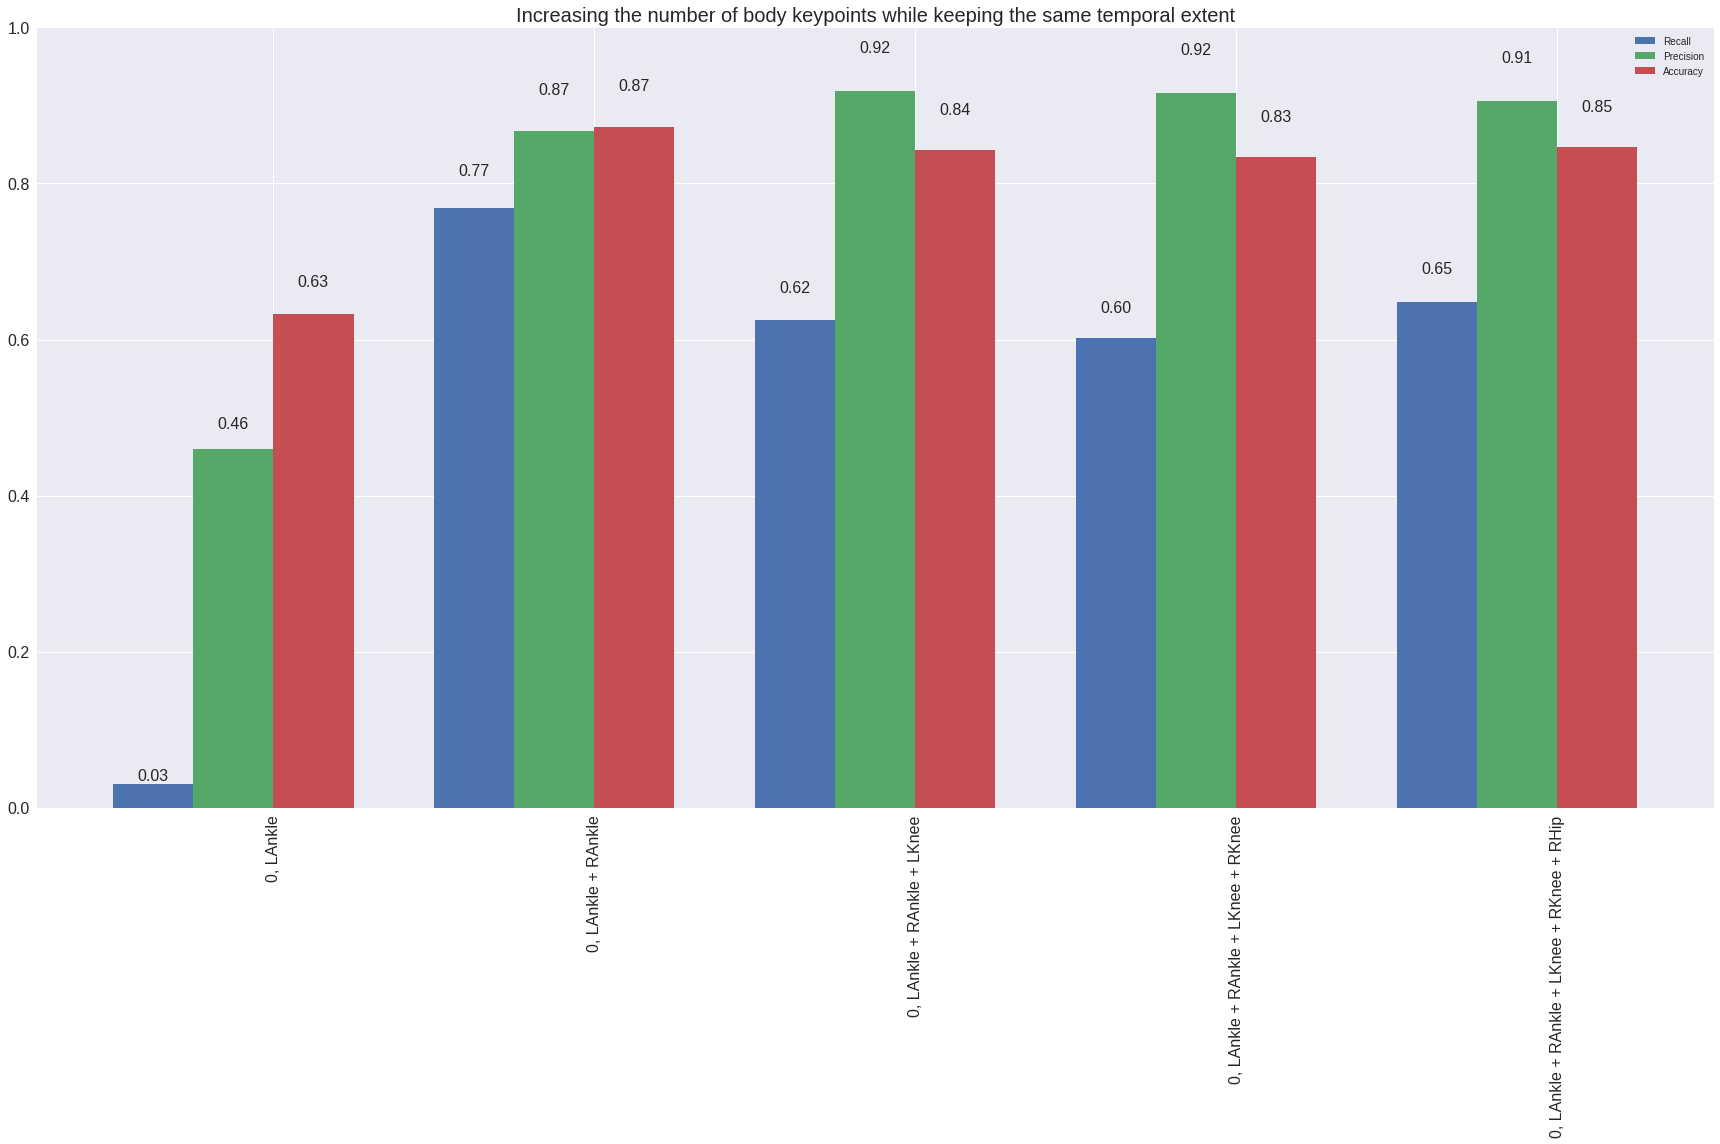

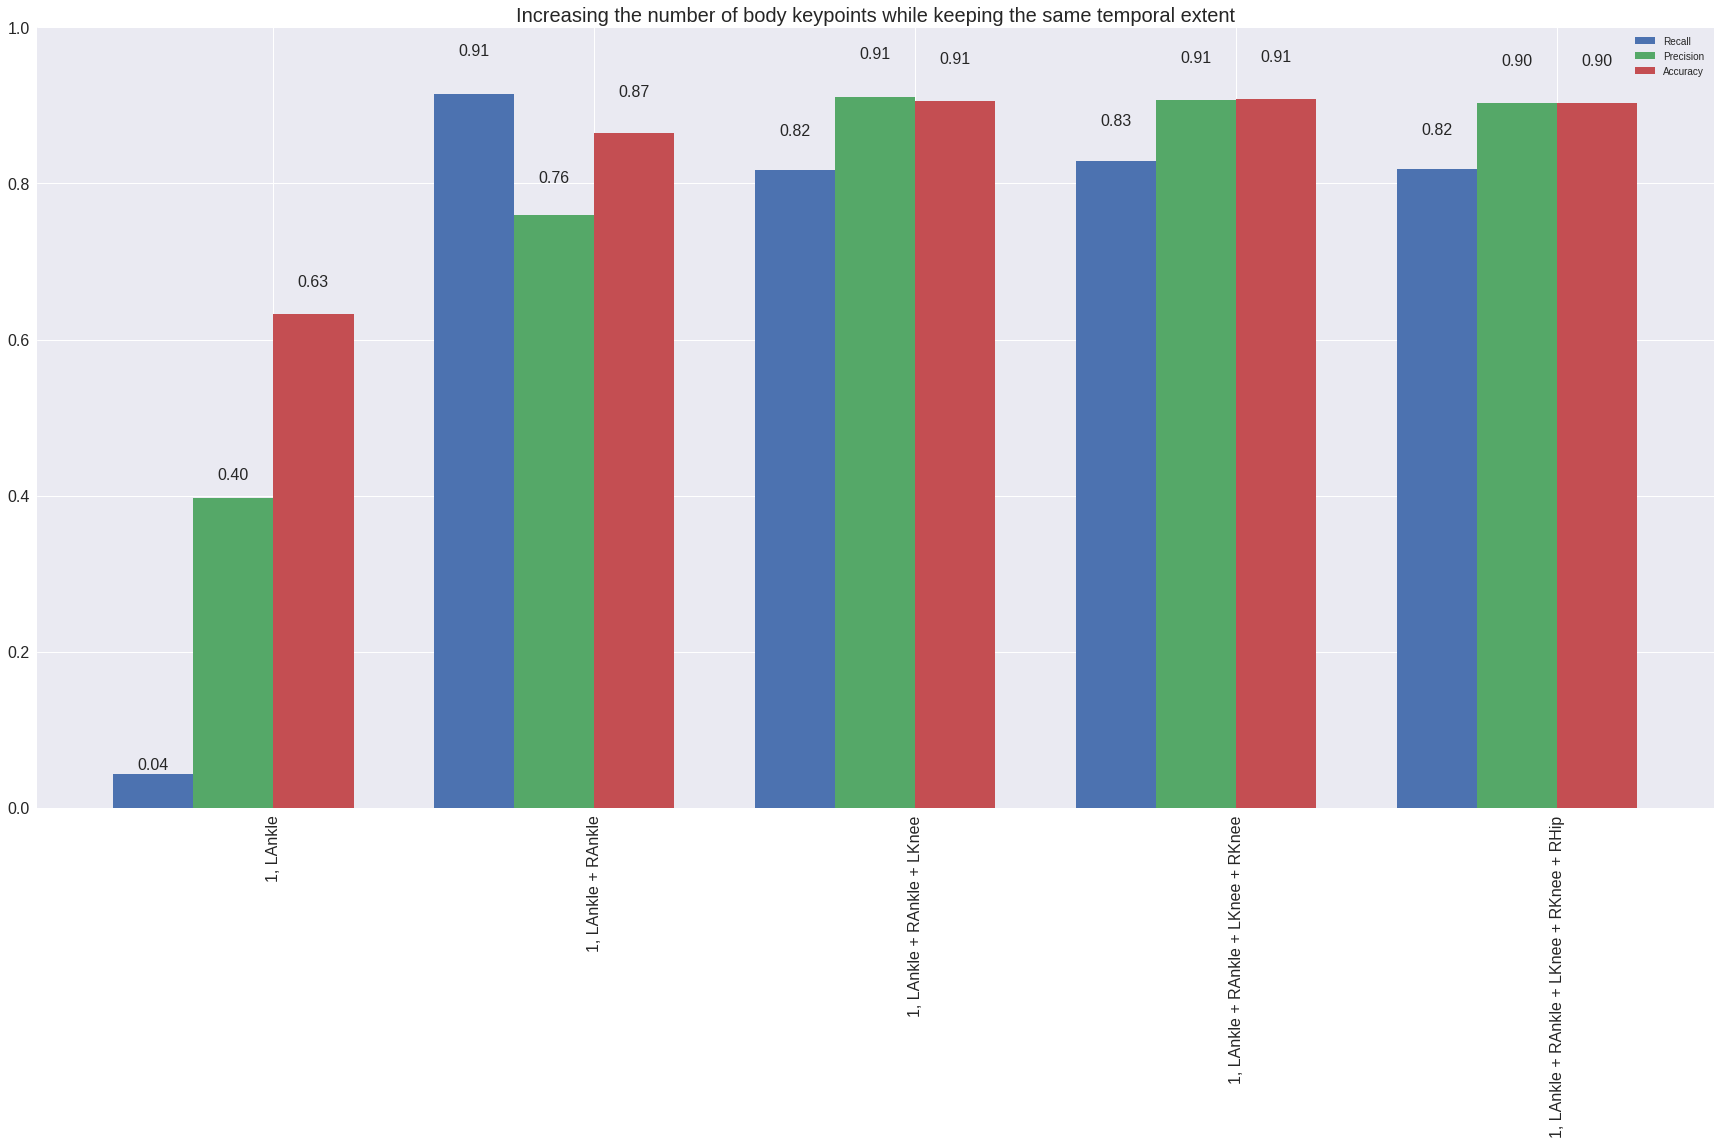

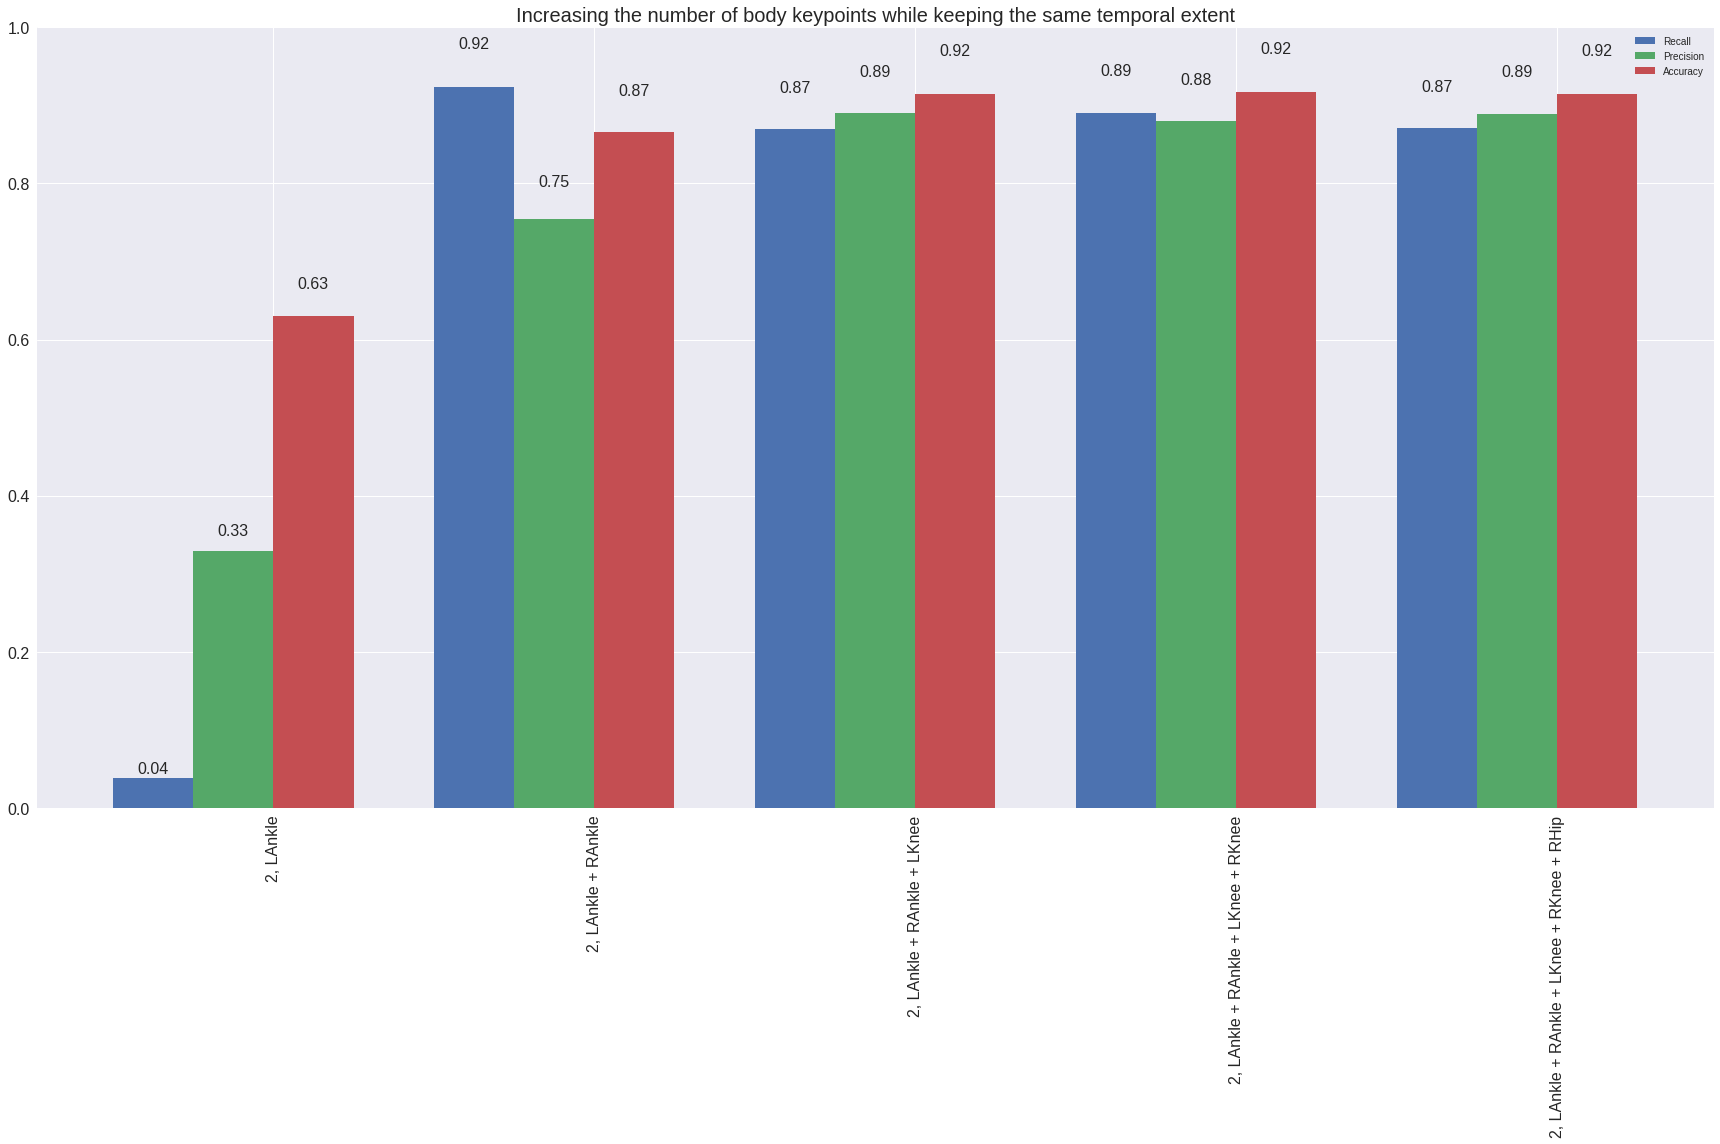

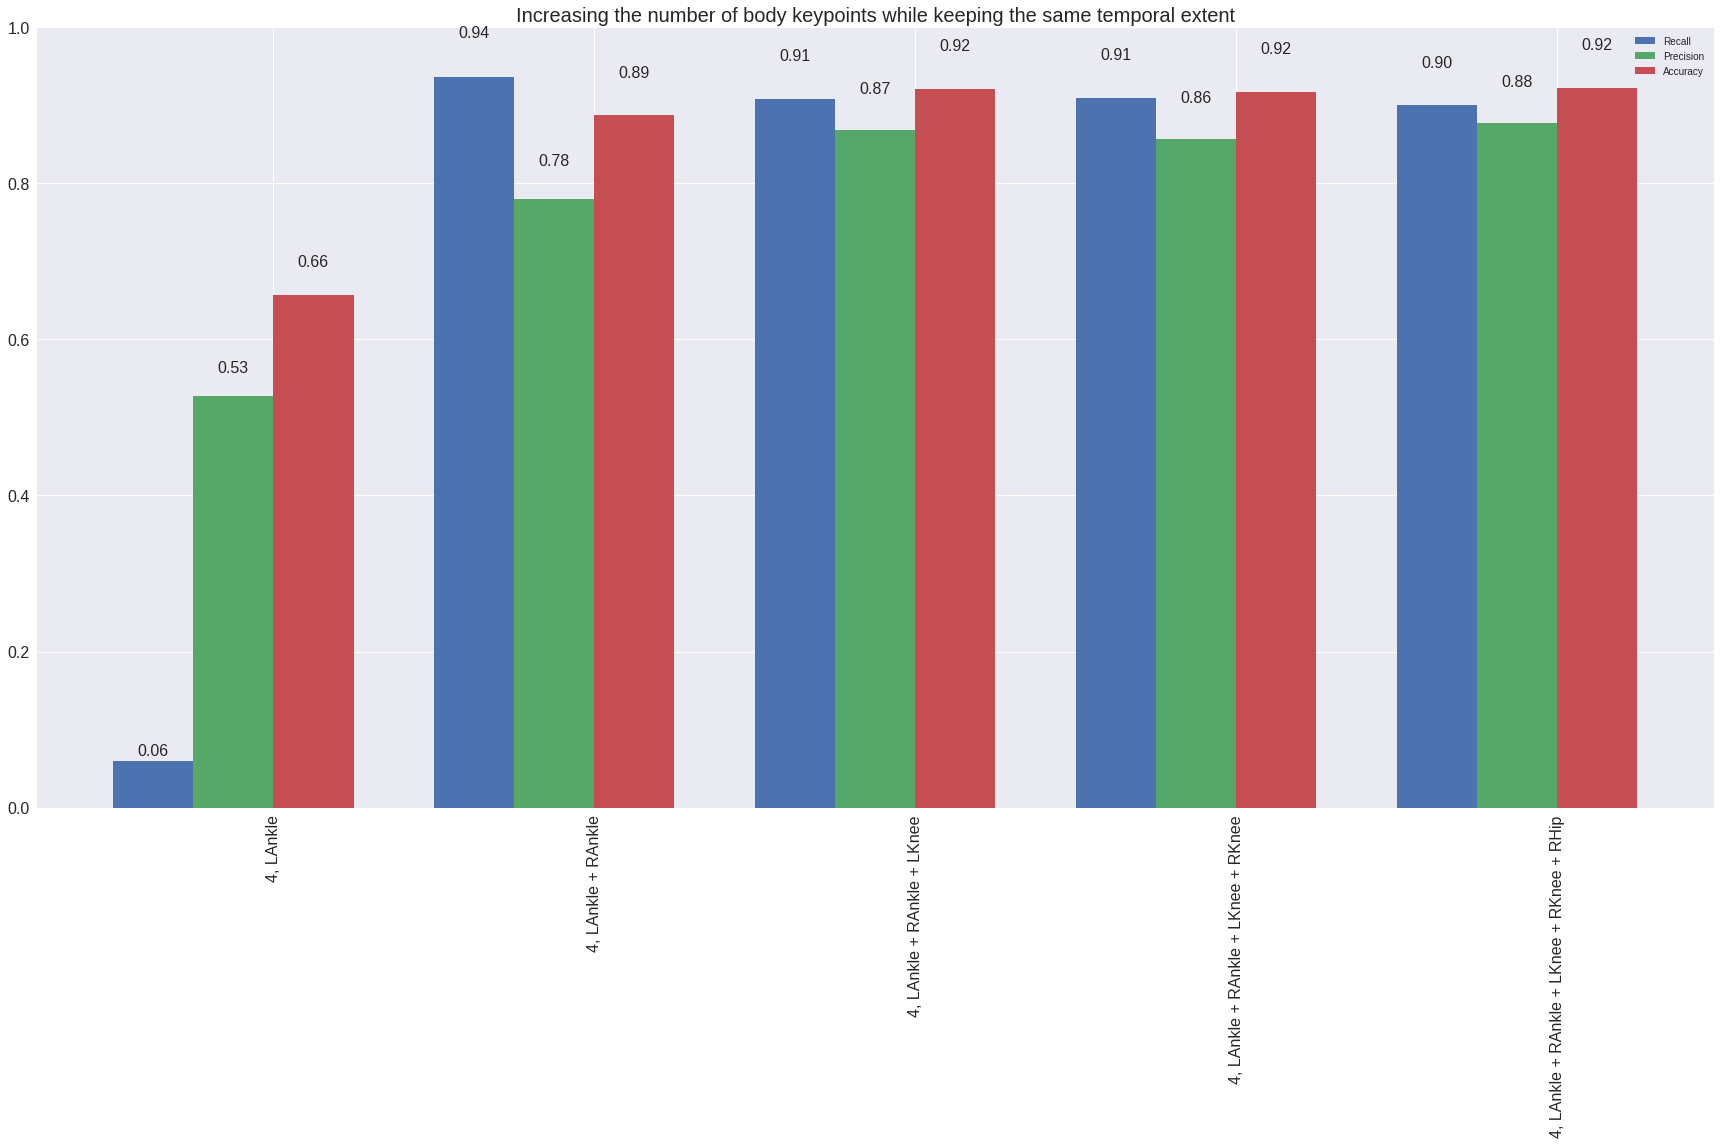

In [55]:
def filter_data_dict(data_dict, slc):
    new_data_dict = {key: (val_tuple[0][slc], None) for key, val_tuple in data_dict.iteritems()}
    return new_data_dict

f_saver.set(5)
for offset in [0, 1, 2, 4]:
    new_data_dict = filter_data_dict(data_dict, slice(offset*5, offset*5+5))
    fig, ax = plt.subplots(1,1, figsize=(24, 16))
    fig, ax = barplot(fig, ax, new_data_dict)
    x_ticks = opt_tuple_string_list[offset*5:offset*5+5]
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=16)
    ax.set_title('Increasing the number of body keypoints while keeping the same temporal extent',
                fontsize=20)
    ax.set_ylim([0, 1])
    fig.tight_layout()
    f_saver.save_fig(fig, 'temporal_extent_is_{}'.format(offset)).next()

# Now lets look at the prediction over the actual sequence

In [39]:
#TODO

In [48]:
# quick and dirty fix: simply copy the plots from the experiments folder
import shutil
import glob
for subfolder, opt_str in zip(sub_folders, opt_tuple_string_list):
    opt_str = opt_str.replace(' ', '_').replace(',', '').replace('+','')
    print(subfolder, opt_str)
    target_dir = os.path.join(report_folder, opt_str)
    mkdir_p(target_dir)
    for f in glob.glob(os.path.join(subfolder, 'dataset_index_*')):
        shutil.copy(f, target_dir)
    

/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/000_2018_06_12-120834 0_LAnkle
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/001_2018_06_12-120904 0_LAnkle__RAnkle
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/002_2018_06_12-120935 0_LAnkle__RAnkle__LKnee
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/003_2018_06_12-121005 0_LAnkle__RAnkle__LKnee__RKnee
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/004_2018_06_12-121037 0_LAnkle__RAnkle__LKnee__RKnee__RHip
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/005_2018_06_12-121110 1_LAnkle
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/006_2018_06_12-121142 1_LAnkle__RAnkle
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/007_2018_06_12-121213 1_LAnkle__RAnkle__LKnee
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/008_2018_06_12-121243 1_LAnkle__RAnkle__LKnee__RKnee
/media/sandro/Volume/Datasets/tumgaid/experiments/exp_1/009_2018_06_12-121314 1_LAnkle__RAnkle__LKn